# Inference plots - Pairwise scatterplots

This example builds on [adaptive covariance MCMC](https://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mc.html), and shows you how to plot the parameter distributions.

Inference plots:
* [Predicted time series](mcmc-predicted-time-series.ipynb)
* [Trace plots](mcmc-trace-plots.ipynb)
* [Autocorrelation](mcmc-autocorrelation.ipynb)

## Setting up an MCMC routine

See the adaptive covariance MCMC example for details.

In [1]:
from __future__ import print_function
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]  # growth rate, carrying capacity
times = np.linspace(0, 1000, 100)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 50
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise*0.1],
    [0.02, 600, noise*100]
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Perform sampling using MCMC, with a single chain
x0 = real_parameters * 1.1
mcmc = pints.MCMCController(log_posterior, 1, [x0])
mcmc.set_max_iterations(6000)
mcmc.set_log_to_screen(False)

## Plotting 1d histograms

We can now run the MCMC routine and plot the histograms of the inferred parameters.

In [2]:
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Done!


In [3]:
# Select chain 0 and discard warm-up
chain = chains[0]
chain = chain[3000:]

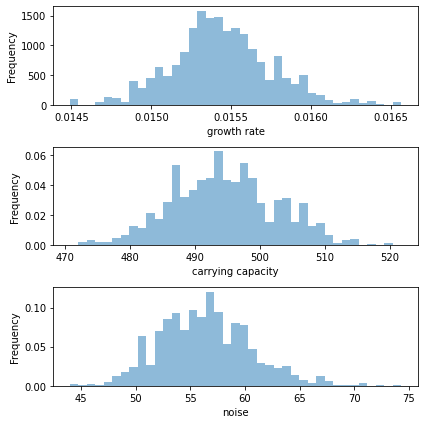

In [4]:
import pints.plot

# Plot the 1d histogram of each parameter
pints.plot.histogram([chain], parameter_names=['growth rate', 'carrying capacity', 'noise'])
plt.show()

## Plotting 2d histograms and a matrix of parameter distribution plots

Plotting the histograms of two variables (showing their correlation) can be performed using `pints.plot.pairwise` with the parameter `heatmap` set to `True`. Additionally, by supplying the known real parameters, we see the locations of the true values appear as dotted lines in each plot.

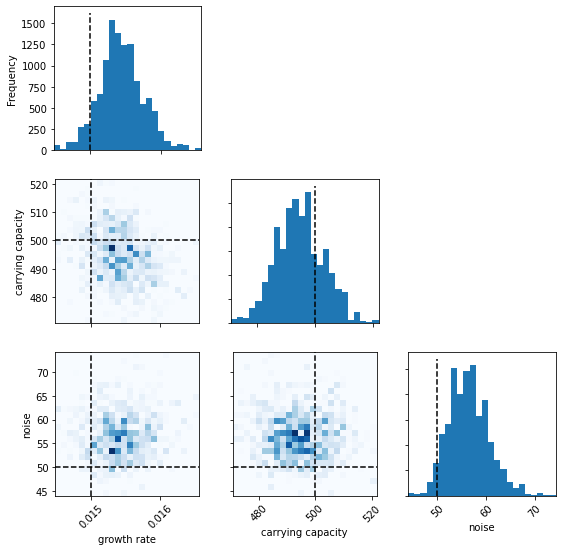

In [5]:
pints.plot.pairwise(chain, heatmap=True, parameter_names=['growth rate', 'carrying capacity', 'noise'], ref_parameters=real_parameters)
plt.show()

## Matrix of parameter distribution plots with KDE

It is also possible to use [kernel density estimation (KDE)](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.stats.gaussian_kde.html) to visualize the probability distributions of each parameter. Using the `pints.plot.pairwise` function, this time with the parameter `kde` set to `True`, we can create a matrix of scatterplots with KDE.

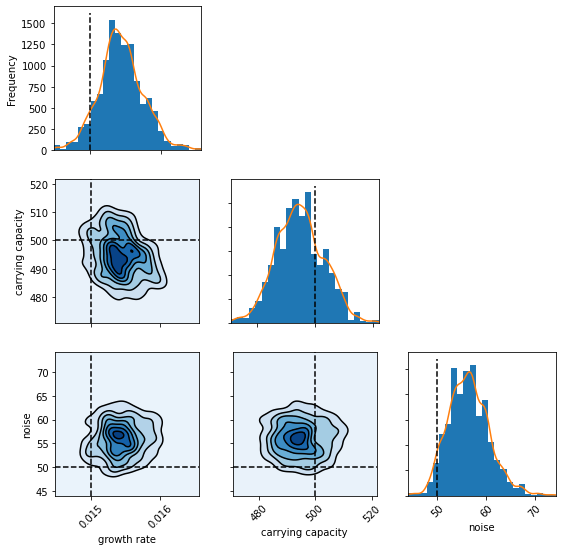

In [6]:
pints.plot.pairwise(chain, kde=True, parameter_names=['growth rate', 'carrying capacity', 'noise'], ref_parameters=real_parameters)
plt.show()